In [30]:
import os
import time
import pandas as pd
import numpy as np
#import yfinance as yf
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType, DoubleType, ArrayType
from pyspark.sql.functions import pandas_udf, udf, col, lag, year, month, row_number

In [31]:
# Crear carpeta temporal Spark
temp_path = os.path.join(os.getcwd(), 'spark-temp')
os.makedirs(temp_path, exist_ok=True)

# Definir variables de entorno
os.environ["JAVA_HOME"] = r"C:\java\jdk"
os.environ['SPARK_LOCAL_DIRS'] = temp_path

print('JAVA_HOME:', os.environ.get('JAVA_HOME'))
print('SPARK_LOCAL_DIRS:', os.environ.get('SPARK_LOCAL_DIRS'))

JAVA_HOME: C:\java\jdk
SPARK_LOCAL_DIRS: C:\Users\TESTER\Desktop\Laboral\GIT\btc-3-asset-portfolio-extension\notebooks\spark-temp


In [32]:
# Crear Spark Session y medir tiempo
start_time = time.time()

spark = SparkSession.builder \
.appName('btcproject') \
    .getOrCreate()
#.config('spark.driver.memory', '8g') \
#.config('spark.executor.memory', '8g') \
#.config('spark.local.dir', temp_path) \


#spark.sparkContext.setLogLevel('ERROR')

end_time = time.time()
print('Spark Version:', spark.version)
print(f'Tiempo total en crear SparkSession: {round(end_time - start_time, 2)} segundos')

Spark Version: 3.5.5
Tiempo total en crear SparkSession: 0.01 segundos


In [33]:
df = spark.read \
.option("header", True) \
.option("inferSchema", True) \
.csv("../data/04/final_btc_ml_dataset.csv")

In [37]:
# Filtrar intervalo temporal
df_filtered = df.filter((F.col("Date") >= "2014-09-17") & (F.col("Date") <= "2021-11-17"))

### --- CORRELAÇÕES DIÁRIAS ---
w_day = Window.orderBy("Date")

returns_daily = df_filtered.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_day)) / F.lag("close_btc").over(w_day) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_day)) / F.lag("close_sp500").over(w_day) * 100) \
    .withColumn("cpi_return", (F.col("cpi") - F.lag("cpi").over(w_day)) / F.lag("cpi").over(w_day) * 100) \
    .dropna()

corr_day_btc_sp = returns_daily.stat.corr("btc_return", "sp500_return")
corr_day_btc_cpi = returns_daily.stat.corr("btc_return", "cpi_return")
corr_day_sp_cpi = returns_daily.stat.corr("sp500_return", "cpi_return")

### --- CORRELAÇÕES MENSAIS (último dia de cada mês) ---
df_month = df_filtered.withColumn("year", F.year("Date")).withColumn("month", F.month("Date"))

w_last = Window.partitionBy("year", "month").orderBy(F.col("Date").desc())
df_last = df_month.withColumn("rn", F.row_number().over(w_last)).filter(F.col("rn") == 1).drop("rn")

w_month = Window.orderBy("year", "month")

returns_month_last = df_last.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_month)) / F.lag("close_btc").over(w_month) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_month)) / F.lag("close_sp500").over(w_month) * 100) \
    .withColumn("cpi_return", (F.col("cpi") - F.lag("cpi").over(w_month)) / F.lag("cpi").over(w_month) * 100) \
    .dropna()

corr_last_btc_sp = returns_month_last.stat.corr("btc_return", "sp500_return")
corr_last_btc_cpi = returns_month_last.stat.corr("btc_return", "cpi_return")
corr_last_sp_cpi = returns_month_last.stat.corr("sp500_return", "cpi_return")

### --- CORRELAÇÕES MENSAIS (média mensal) ---
monthly_avg_df = df_month.groupBy("year", "month").agg(
    F.avg("close_btc").alias("close_btc"),
    F.avg("close_sp500").alias("close_sp500"),
    F.avg("cpi").alias("avg_cpi")
)

returns_month_avg = monthly_avg_df.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_month)) / F.lag("close_btc").over(w_month) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_month)) / F.lag("close_sp500").over(w_month) * 100) \
    .withColumn("cpi_return", (F.col("avg_cpi") - F.lag("avg_cpi").over(w_month)) / F.lag("avg_cpi").over(w_month) * 100) \
    .dropna()

corr_avg_btc_sp = returns_month_avg.stat.corr("btc_return", "sp500_return")
corr_avg_btc_cpi = returns_month_avg.stat.corr("btc_return", "cpi_return")
corr_avg_sp_cpi = returns_month_avg.stat.corr("sp500_return", "cpi_return")

### --- PRINT FINAL RESUMIDO ---
print("\n--------- Correlações entre o dia 2014-09-17 e 2021-11-17 ---------")
print("\n--- Correlações Diárias ---")
print("BTC vs SP500:", round(corr_day_btc_sp, 2))
print("BTC vs CPI:", round(corr_day_btc_cpi, 2))
print("SP500 vs CPI:", round(corr_day_sp_cpi, 2))

print("\n--- Correlações Mensais (Último dia do mês) ---")
print("BTC vs SP500:", round(corr_last_btc_sp, 2))
print("BTC vs CPI:", round(corr_last_btc_cpi, 2))
print("SP500 vs CPI:", round(corr_last_sp_cpi, 2))

print("\n--- Correlações Mensais (Média mensal) ---")
print("BTC vs SP500:", round(corr_avg_btc_sp, 2))
print("BTC vs CPI:", round(corr_avg_btc_cpi, 2))
print("SP500 vs CPI:", round(corr_avg_sp_cpi, 2))


--------- Correlações entre o dia 2014-09-17 e 2021-11-17 ---------

--- Correlações Diárias ---
BTC vs SP500: 0.16
BTC vs CPI: 0.01
SP500 vs CPI: 0.09

--- Correlações Mensais (Último dia do mês) ---
BTC vs SP500: 0.2
BTC vs CPI: -0.04
SP500 vs CPI: 0.14

--- Correlações Mensais (Média mensal) ---
BTC vs SP500: 0.33
BTC vs CPI: 0.11
SP500 vs CPI: 0.35


In [40]:
df_filtered = df

In [42]:
### 1. CORRELAÇÕES DIÁRIAS ###
w_day = Window.orderBy("Date")
returns_daily = df_filtered.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_day)) / F.lag("close_btc").over(w_day) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_day)) / F.lag("close_sp500").over(w_day) * 100) \
    .withColumn("cpi_return", (F.col("cpi") - F.lag("cpi").over(w_day)) / F.lag("cpi").over(w_day) * 100) \
    .withColumn("reward_return", (F.col("block_reward") - F.lag("block_reward").over(w_day)) / F.lag("block_reward").over(w_day) * 100) \
    .withColumn("usdchf_return", (F.col("USDCHF") - F.lag("USDCHF").over(w_day)) / F.lag("USDCHF").over(w_day) * 100) \
    .withColumn("eurchf_return", (F.col("EURCHF") - F.lag("EURCHF").over(w_day)) / F.lag("EURCHF").over(w_day) * 100) \
    .dropna()

corr_day_btc_sp = returns_daily.stat.corr("btc_return", "sp500_return")
corr_day_btc_cpi = returns_daily.stat.corr("btc_return", "cpi_return")
corr_day_btc_reward = returns_daily.stat.corr("btc_return", "reward_return")
corr_day_btc_usdchf = returns_daily.stat.corr("btc_return", "usdchf_return")
corr_day_btc_eurchf = returns_daily.stat.corr("btc_return", "eurchf_return")

### 2. CORRELAÇÕES MENSAIS (último dia) ###
df_month = df_filtered.withColumn("year", F.year("Date")).withColumn("month", F.month("Date"))
w_last = Window.partitionBy("year", "month").orderBy(F.col("Date").desc())
df_last = df_month.withColumn("rn", F.row_number().over(w_last)).filter(F.col("rn") == 1).drop("rn").orderBy("year", "month")

w_month = Window.orderBy("year", "month")
returns_last = df_last.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_month)) / F.lag("close_btc").over(w_month) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_month)) / F.lag("close_sp500").over(w_month) * 100) \
    .withColumn("cpi_return", (F.col("cpi") - F.lag("cpi").over(w_month)) / F.lag("cpi").over(w_month) * 100) \
    .withColumn("reward_return", (F.col("block_reward") - F.lag("block_reward").over(w_month)) / F.lag("block_reward").over(w_month) * 100) \
    .withColumn("usdchf_return", (F.col("USDCHF") - F.lag("USDCHF").over(w_month)) / F.lag("USDCHF").over(w_month) * 100) \
    .withColumn("eurchf_return", (F.col("EURCHF") - F.lag("EURCHF").over(w_month)) / F.lag("EURCHF").over(w_month) * 100) \
    .dropna()

corr_last_btc_sp = returns_last.stat.corr("btc_return", "sp500_return")
corr_last_btc_cpi = returns_last.stat.corr("btc_return", "cpi_return")
corr_last_btc_reward = returns_last.stat.corr("btc_return", "reward_return")
corr_last_btc_usdchf = returns_last.stat.corr("btc_return", "usdchf_return")
corr_last_btc_eurchf = returns_last.stat.corr("btc_return", "eurchf_return")

### 3. CORRELAÇÕES MENSAIS (média) ###
monthly_avg = df_month.groupBy("year", "month").agg(
    F.avg("close_btc").alias("close_btc"),
    F.avg("close_sp500").alias("close_sp500"),
    F.avg("cpi").alias("cpi"),
    F.avg("block_reward").alias("block_reward"),
    F.avg("USDCHF").alias("USDCHF"),
    F.avg("EURCHF").alias("EURCHF")
)

returns_avg = monthly_avg.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_month)) / F.lag("close_btc").over(w_month) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_month)) / F.lag("close_sp500").over(w_month) * 100) \
    .withColumn("cpi_return", (F.col("cpi") - F.lag("cpi").over(w_month)) / F.lag("cpi").over(w_month) * 100) \
    .withColumn("reward_return", (F.col("block_reward") - F.lag("block_reward").over(w_month)) / F.lag("block_reward").over(w_month) * 100) \
    .withColumn("usdchf_return", (F.col("USDCHF") - F.lag("USDCHF").over(w_month)) / F.lag("USDCHF").over(w_month) * 100) \
    .withColumn("eurchf_return", (F.col("EURCHF") - F.lag("EURCHF").over(w_month)) / F.lag("EURCHF").over(w_month) * 100) \
    .dropna()

corr_avg_btc_sp = returns_avg.stat.corr("btc_return", "sp500_return")
corr_avg_btc_cpi = returns_avg.stat.corr("btc_return", "cpi_return")
corr_avg_btc_reward = returns_avg.stat.corr("btc_return", "reward_return")
corr_avg_btc_usdchf = returns_avg.stat.corr("btc_return", "usdchf_return")
corr_avg_btc_eurchf = returns_avg.stat.corr("btc_return", "eurchf_return")

### 4. CORRELAÇÕES TRIMESTRAIS (últimos de mar/jun/set/dez) ###
df_q = df_filtered.withColumn("year", F.year("Date")) \
                  .withColumn("month", F.month("Date")) \
                  .filter(F.col("month").isin(3, 6, 9, 12))

w_q = Window.partitionBy("year", "month").orderBy(F.col("Date").desc())
df_q_last = df_q.withColumn("rn", F.row_number().over(w_q)) \
                .filter(F.col("rn") == 1).drop("rn").orderBy("year", "month")

returns_q = df_q_last.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_month)) / F.lag("close_btc").over(w_month) * 100) \
    .withColumn("sp500_return", (F.col("close_sp500") - F.lag("close_sp500").over(w_month)) / F.lag("close_sp500").over(w_month) * 100) \
    .withColumn("cpi_return", (F.col("cpi") - F.lag("cpi").over(w_month)) / F.lag("cpi").over(w_month) * 100) \
    .withColumn("reward_return", (F.col("block_reward") - F.lag("block_reward").over(w_month)) / F.lag("block_reward").over(w_month) * 100) \
    .withColumn("usdchf_return", (F.col("USDCHF") - F.lag("USDCHF").over(w_month)) / F.lag("USDCHF").over(w_month) * 100) \
    .withColumn("eurchf_return", (F.col("EURCHF") - F.lag("EURCHF").over(w_month)) / F.lag("EURCHF").over(w_month) * 100) \
    .dropna()

corr_q_btc_sp = returns_q.stat.corr("btc_return", "sp500_return")
corr_q_btc_cpi = returns_q.stat.corr("btc_return", "cpi_return")
corr_q_btc_reward = returns_q.stat.corr("btc_return", "reward_return")
corr_q_btc_usdchf = returns_q.stat.corr("btc_return", "usdchf_return")
corr_q_btc_eurchf = returns_q.stat.corr("btc_return", "eurchf_return")

### PRINT FINAL ###
print("\n--- Correlações Diárias ---")
print("BTC vs SP500:", round(corr_day_btc_sp, 2))
print("BTC vs CPI:", round(corr_day_btc_cpi, 2))
print("BTC vs Block Reward:", round(corr_day_btc_reward, 2))
print("BTC vs USDCHF:", round(corr_day_btc_usdchf, 2))
print("BTC vs EURCHF:", round(corr_day_btc_eurchf, 2))

print("\n--- Correlações Mensais (Último dia) ---")
print("BTC vs SP500:", round(corr_last_btc_sp, 2))
print("BTC vs CPI:", round(corr_last_btc_cpi, 2))
print("BTC vs Block Reward:", round(corr_last_btc_reward, 2))
print("BTC vs USDCHF:", round(corr_last_btc_usdchf, 2))
print("BTC vs EURCHF:", round(corr_last_btc_eurchf, 2))

print("\n--- Correlações Mensais (Média mensal) ---")
print("BTC vs SP500:", round(corr_avg_btc_sp, 2))
print("BTC vs CPI:", round(corr_avg_btc_cpi, 2))
print("BTC vs Block Reward:", round(corr_avg_btc_reward, 2))
print("BTC vs USDCHF:", round(corr_avg_btc_usdchf, 2))
print("BTC vs EURCHF:", round(corr_avg_btc_eurchf, 2))

print("\n--- Correlações Trimestrais (Últimos de Mar/Jun/Set/Dez) ---")
print("BTC vs SP500:", round(corr_q_btc_sp, 2))
print("BTC vs CPI:", round(corr_q_btc_cpi, 2))
print("BTC vs Block Reward:", round(corr_q_btc_reward, 2))
print("BTC vs USDCHF:", round(corr_q_btc_usdchf, 2))
print("BTC vs EURCHF:", round(corr_q_btc_eurchf, 2))


--- Correlações Diárias ---
BTC vs SP500: 0.15
BTC vs CPI: 0.02
BTC vs Block Reward: -0.01
BTC vs USDCHF: -0.07
BTC vs EURCHF: -0.04

--- Correlações Mensais (Último dia) ---
BTC vs SP500: 0.15
BTC vs CPI: -0.11
BTC vs Block Reward: -0.02
BTC vs USDCHF: -0.12
BTC vs EURCHF: -0.01

--- Correlações Mensais (Média mensal) ---
BTC vs SP500: 0.17
BTC vs CPI: -0.02
BTC vs Block Reward: 0.03
BTC vs USDCHF: -0.08
BTC vs EURCHF: -0.07

--- Correlações Trimestrais (Últimos de Mar/Jun/Set/Dez) ---
BTC vs SP500: 0.09
BTC vs CPI: -0.01
BTC vs Block Reward: 0.07
BTC vs USDCHF: -0.45
BTC vs EURCHF: -0.28


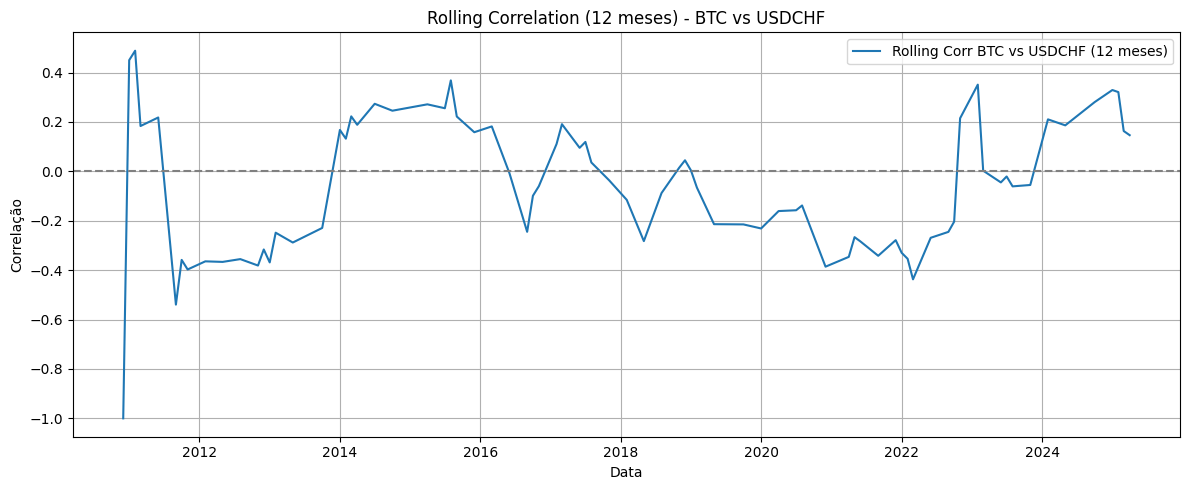

In [43]:
# 1. Preparar dados mensais (último dia de cada mês)
df_month = df.withColumn("year", F.year("Date")).withColumn("month", F.month("Date"))
w_last = Window.partitionBy("year", "month").orderBy(F.col("Date").desc())
df_last = df_month.withColumn("rn", F.row_number().over(w_last)).filter(F.col("rn") == 1).drop("rn").orderBy("year", "month")

# 2. Calcular retornos percentuais
w_lag = Window.orderBy("year", "month")
df_ret = df_last.withColumn("btc_return", (F.col("close_btc") - F.lag("close_btc").over(w_lag)) / F.lag("close_btc").over(w_lag) * 100) \
    .withColumn("usdchf_return", (F.col("USDCHF") - F.lag("USDCHF").over(w_lag)) / F.lag("USDCHF").over(w_lag) * 100) \
    .dropna()

# 3. Calcular rolling correlation de 12 meses
w_rolling = Window.orderBy("year", "month").rowsBetween(-11, 0)
rolling_corr_df = df_ret.withColumn("rolling_corr_12m", F.corr("btc_return", "usdchf_return").over(w_rolling))

# 4. Converter para Pandas e desenhar gráfico
rolling_corr_pd = rolling_corr_df.select("year", "month", "rolling_corr_12m") \
    .withColumn("date", F.to_date(F.concat_ws("-", F.col("year"), F.col("month"), F.lit("1")))) \
    .orderBy("date").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(rolling_corr_pd["date"], rolling_corr_pd["rolling_corr_12m"], label="Rolling Corr BTC vs USDCHF (12 meses)")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Rolling Correlation (12 meses) - BTC vs USDCHF")
plt.xlabel("Data")
plt.ylabel("Correlação")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()